✅ Dataset extracted successfully!
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
✅ Train samples: 11230
✅ Validation samples: 2804
✅ Test samples: 3000
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 195s 518ms/step - accuracy: 0.2521 - loss: 1.7607 - val_accuracy: 0.3028 - val_loss: 1.5682 - learning_rate: 1.0000e-04
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 166s 473ms/step - accuracy: 0.3786 - loss: 1.5053 - val_accuracy: 0.3873 - val_loss: 1.4490 - learning_rate: 1.0000e-04
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 173s 493ms/step - accuracy: 0.4291 - loss: 1.4043 - val_accuracy: 0.4130 - val_loss: 1.3811 - learning_rate: 1.0000e-04
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 168s 478ms/step - accuracy: 0.4537 - loss: 1.3576 - val_accuracy: 0.4675 - val_loss: 1.3272 - learning_rate: 1.0000e-04
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 165s 471ms/step - accuracy: 0.4760 - loss: 1.3161 - val_accuracy: 0.5029 - val_loss: 1.2957 - learning_rate: 1.0000e-04
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 166s 474ms/step - accuracy: 0.5011 - loss: 1.2713 - val_accuracy: 0.5014 - val_loss: 1.2674 - learning_rate: 1.0000e-04
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 

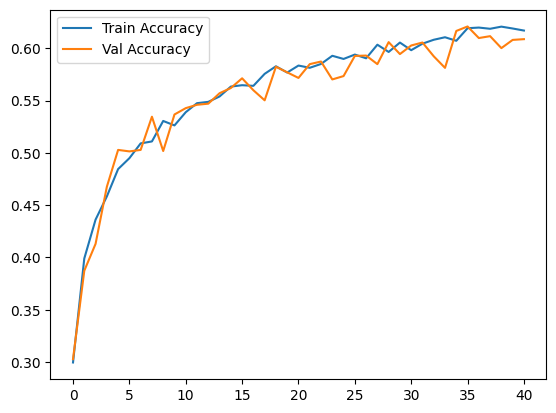

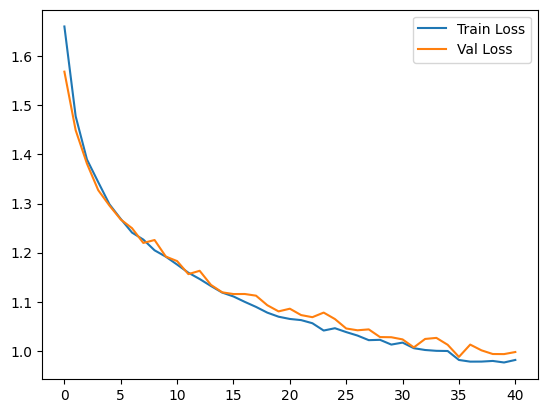

94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.6756 - loss: 0.8219
✅ Test Accuracy: 0.6293


In [1]:
# ==========================
# 1️⃣ IMPORTS
# ==========================
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==========================
# 2️⃣ EXTRACT DATASET
# ==========================
zip_path = "/content/drive/MyDrive/archive.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("✅ Dataset extracted successfully!")

# ==========================
# 3️⃣ DEFINE DIRECTORIES
# Structure after extraction:
# /content/dataset/seg_train/seg_train/{6 classes}
# /content/dataset/seg_test/seg_test/{6 classes}
# /content/dataset/seg_pred/seg_pred/{...}
# ==========================
train_dir = os.path.join(extract_path, "seg_train", "seg_train")
test_dir  = os.path.join(extract_path, "seg_test", "seg_test")
pred_dir  = os.path.join(extract_path, "seg_pred", "seg_pred")

# ==========================
# 4️⃣ DATA PREPROCESSING
# ==========================
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Split training data into train/val
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Train
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Validation
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"✅ Train samples: {train_generator.samples}")
print(f"✅ Validation samples: {val_generator.samples}")
print(f"✅ Test samples: {test_generator.samples}")

# ==========================
# 5️⃣ MODEL (ResNet50 Transfer Learning)
# ==========================
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base model layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ==========================
# 6️⃣ CALLBACKS
# ==========================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# ==========================
# 7️⃣ TRAINING
# ==========================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

# ==========================
# 8️⃣ PLOT ACCURACY & LOSS
# ==========================
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

# ==========================
# 9️⃣ FINAL EVALUATION ON TEST SET
# ==========================
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc:.4f}")


In [3]:
# Save in Keras native format (.keras)
model.save("emotion_model.keras")

# Save in HDF5 format (.h5)
model.save("emotion_model.h5")

print("Model saved successfully!")



Model saved successfully!


In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load the saved model
model = load_model("/content/emotion_model.h5")

# Path to test set
test_dir = "/content/dataset/seg_test/seg_test"

# Create test generator with correct target size
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # MATCH model input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")
print(f"✅ Test Loss: {loss:.4f}")

Found 3000 images belonging to 6 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.6756 - loss: 0.8219
✅ Test Accuracy: 62.93%
✅ Test Loss: 0.9321
